### Что будем делать:

- Сконвертируем картиночную модель
- Проверим "правильность" конвертации
- Подготовим тритон компоненты и тритон ансамбль
- Проверим работоспособность ансамбля

# ResNet

### Возьмем простой картиночный энкодер

ResNet, что нужно знать:
- на вход принимает изображение размеров 224х224
- на выход отдает эмбеддинг 1х1000

In [2]:
from torchvision.models import resnet50, ResNet50_Weights
import onnx
import onnxruntime as ort
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.eval()
print()

### Создадим случайную картинку нужного размера и проинферим модель 

In [4]:
dummy_input_resnet = torch.rand((1, 3, 224, 224))

In [5]:
resnet_output = resnet(dummy_input_resnet)

In [6]:
resnet_output.mean(), resnet_output.size()

(tensor(0.0001, grad_fn=<MeanBackward0>), torch.Size([1, 1000]))

### Сконвертируем модель в ONNX формат

In [7]:
save = './model.onnx'

torch.onnx.export(
    resnet,
    dummy_input_resnet,
    save,
    export_params=True,
    opset_version=18,
    do_constant_folding=False,
    input_names=["image"],
    output_names=["embedding"],
    dynamic_axes={"image": {0: "batch_size"}, "embedding": {0: "batch_size"}}
)



# Check onnx runtime and Ensembles

In [8]:
onnx_renset = onnx.load("./model.onnx")
onnx.checker.check_model(onnx_renset)

In [9]:
output_name =[node.name for node in onnx_renset.graph.output]

input_name = [node.name for node in onnx_renset.graph.input]
input_name, output_name

(['image'], ['embedding'])

In [10]:
ort_sess = ort.InferenceSession('./triton/resnet_inference/1/model.onnx')

In [11]:
onnx_outputs = ort_sess.run(None, {'image': dummy_input_resnet.numpy()})
torch_outputs = resnet(dummy_input_resnet)

In [12]:
np.linalg.norm(torch_outputs.detach().numpy() - onnx_outputs)

1.6261436e-05

In [ ]:
!cp ./model.onnx ./triton/resnet_inference/1/

### Теперь перейдем к тритон компонентам:

Нужно:
- сделать **препроцессинг** на python-backend (**triton/resnet_preprocessing**)
- сделать **инференс** на onnx-backend (**triton/resnet_inference**)
- сделать **постпроцессинг** на python-backend (**triton/resnet_postprocessing**)

### Preprocessing:

#### Нужно:

- конда окружение с PIL/numpy
- config.pbtxt с определенными входами/выходами
- model.py - логика препроцессинга

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


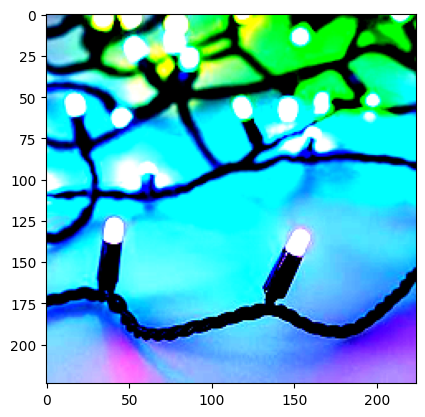

In [14]:
inputs_data = np.load("infer_inputs.npy")
plt.imshow(inputs_data[0].transpose((1,2,0)))

In [15]:
inputs_data[0].dtype

dtype('float32')

### Inference:

#### Нужно:

- ONNX модель
- config.pbtxt с определенными входами/выходами


In [16]:
onnx_results = np.load("infer_outputs.npy")
torch_outputs = resnet(torch.tensor(inputs_data))
np.linalg.norm(torch_outputs.detach().numpy() - onnx_results, axis=1)

array([0.01273272, 0.00981045, 0.00902966, 0.01131075, 0.00903779,
       0.01378413, 0.01233278, 0.00944942, 0.00693706, 0.00964544,
       0.0064985 , 0.00878808, 0.0073195 , 0.00684316, 0.00948422],
      dtype=float32)

In [ ]:
!touch triton/resnet_ensemble/1/dummy

### PostProcessing:

In [17]:
!touch triton/resnet_ensemble/1/dummy

In [18]:
model_inference_results = np.load("infer_outputs.npy")
ensemble_results = np.load("ensemble_outputs.npy")

In [19]:
np.linalg.norm(model_inference_results - ensemble_results, axis=1)

array([0.00901499, 0.01097411, 0.00657198, 0.00758673, 0.00917473,
       0.00917306, 0.00918826, 0.00572746, 0.00439937, 0.00675311,
       0.00462823, 0.00582775, 0.        , 0.        , 0.        ],
      dtype=float32)

#### Нужно:

- config.pbtxt с определенными входами/выходами
- model.py - логика препроцессинга

In [ ]:
inputs_data = np.load("infer_inputs.npy")
ensemble_outputs = np.load("ensemble_outputs.npy")

with torch.no_grad():
    torch_out = resnet(torch.tensor(inputs_data, dtype=torch.float32)).detach().numpy()

In [ ]:
onnx_outputs = ort_sess.run(None, {'image': inputs_data})

In [ ]:
np.linalg.norm(torch_out - ensemble_outputs, axis=1)

In [ ]:
np.linalg.norm(onnx_outputs[0] - ensemble_outputs, axis=1)

In [ ]:
np.linalg.norm(torch_out - onnx_outputs[0], axis=1)

### Усложним логику, сделаем два препроцессинга, которые потом усредним

- Первый препроцессинг будет нормализовать изображения (уже готово)
- Второй препроцессинг не будет нормализовать изображения

Затем понадобится компонента для их усреднения, чтобы итоговая размерность была [3, 224, 224]

In [20]:
inputs_data = np.load("infer_inputs.npy")
inputs_data_v2 = np.load("infer_inputs_v2.npy")
inputs_data_concat = np.load("infer_inputs_concat.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


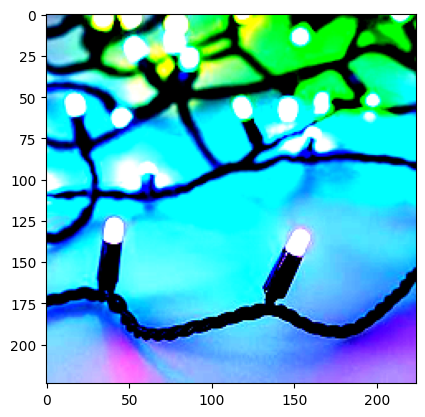

In [21]:
plt.imshow(inputs_data[0].transpose((1,2,0)))

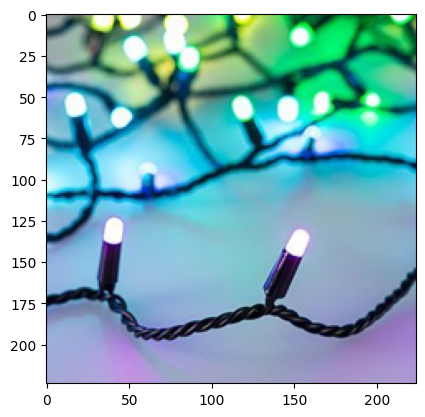

In [22]:
plt.imshow(inputs_data_v2[0].transpose((1,2,0)).astype(int))

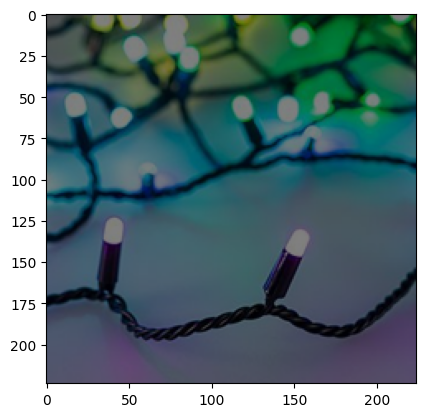

In [23]:
plt.imshow(inputs_data_concat[0].transpose((1,2,0)).astype(int))